<h1> TP INTEGRADOR - ANALISIS DE SENTIMIENTOS </h1> 

Esta notebook permite correr un pipeline con muchos modelos pero con pocos datos cada vez.

1) Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

c:\Users\anacl\.conda\envs\dhdsblend2021\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anacl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anacl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Lectura del archivo y cuesitones básicas de shape, tipos de datos, búsquedas de nulos.

In [2]:
data=pd.read_csv("Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
data.shape

(568454, 10)

In [4]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [5]:
data.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

#Los nulls en ProfileName no son relevantes porque esa columna no se usa. Los de Summary se tratarán en el pipeline.

In [6]:
data.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

Clase para crear la columna Sentiment.

In [7]:
class CrearSentiment(BaseEstimator, TransformerMixin):
    """Acepta como parámetro la columna a partir de la cual crear el sentiment (ej: Score o Rating) y el mínimo score para considerar el sentiment como positivo. Al sentiment positivo le asigna 0, al sentiment negativo le asigna 1."""
    def __init__(self,columna_a_transformar,minimo):
        self.columna_a_transformar = columna_a_transformar
        self.minimo = minimo

    def fit(self,X,y=None):
        return self
    
    def transform(self, X, y=None):
        X["Sentiment"]=X[self.columna_a_transformar]>self.minimo
        X["Sentiment"]=X["Sentiment"].apply(lambda x: 0 if x else 1)
        return X

Consideramos negativos los que tienen score 1 ó 2. Sentiment=1 es negativo, Sentiment=0 es positivo.

In [8]:
#La columna target no se puede trabajar dentro del pipeline porque en producción no la tendríamos.
crearSentiment=CrearSentiment("Score",2)
crearSentiment.transform(data)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0
...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,0
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,1
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",0
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,0


In [9]:
data.Sentiment.value_counts()

0    486417
1     82037
Name: Sentiment, dtype: int64

In [10]:
data.Sentiment.value_counts(normalize=True)

0    0.855684
1    0.144316
Name: Sentiment, dtype: float64

Ho: 85,6%

Clases para el procesamiento.

In [11]:
class DropDuplicated(BaseEstimator, TransformerMixin):
    """Acepta como parámetro las columnas a partir de las cuales considerar registros como duplicados."""
    def __init__(self,columnas_decision):
        self.columnas_decision = columnas_decision

    def fit(self,X,y=None):
        return self
    
    def transform(self, X, y=None):
        X=X.drop_duplicates(subset=self.columnas_decision)
        return X

In [12]:
dropDuplicated=DropDuplicated(["UserId","Text","ProductId"])
dropDuplicated.transform(data)
#Esto tb se tiene que hacer fuera del pipeline en train. Si lo hiciéramos dentro del pipeline pueden quedar de diferente tamaño X e y. 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0
...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,0
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,1
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",0
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,0


In [13]:
class FillNa(BaseEstimator, TransformerMixin):
    """Acepta como parámetro una columna del dataframe para rellenar, y con qué rellenarla. Se aplica primero."""
    def __init__(self,relleno,columna_a_rellenar):
        self.relleno = relleno
        self.columna_a_rellenar=columna_a_rellenar
    
    def fit(self,X,y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.concat([X[self.columna_a_rellenar].fillna(value=self.relleno),X.drop(self.columna_a_rellenar,axis=1)],axis=1) 


In [14]:
class UnirColumnas(BaseEstimator, TransformerMixin):
    """Acepta como parámetro las columnas a unir."""
    def __init__(self,columna1,columna2):
        self.columna1 = columna1
        self.columna2 = columna2

    def fit(self,X,y=None):
        return self
    
    def transform(self, X, y=None):
         X.loc[:,self.columna1+' '+self.columna2]=X[self.columna1]+ " " + X[self.columna2]
         return pd.DataFrame(X)

In [15]:
class FeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self,selected_features):
        self.selected_features=selected_features

    def fit(self,X,y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.selected_features]

In [16]:
englishStemmer=SnowballStemmer("english")
stopwords_en = stopwords.words('english');
stopwords_en_stem = [englishStemmer.stem(x) for x in stopwords_en]

In [17]:
def stemfrases(frase):    
    token_words=word_tokenize(frase)
    stem_sentence=[]    
    englishStemmer=SnowballStemmer("english")
    for word in token_words:
        stem_sentence.append(englishStemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)


In [18]:
class Stemmer_English(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self
    
    def transform(self, X, y=None):
        return X.apply(lambda x: stemfrases(x))

Esto que sigue es para probar el código completo en una pequeña muestra. Si le ponemos tamaño de muestra igual a la cantidad de datos, corre sobre el dataset completo.

In [19]:
tamano_muestra=100

In [20]:
y=data.Sentiment
train,test=train_test_split(data,stratify=y,test_size=0.3,random_state=42)

In [21]:
proporcion_negativos=data.Sentiment.value_counts(normalize=True)[1]
#Este número sale del value_counts de Sentiment, para respetar la proporción de negativos y positivos.

In [22]:
tamano_negativo=int(tamano_muestra*proporcion_negativos)
tamano_positivo=tamano_muestra-tamano_negativo

In [23]:
train_1=train[train.Sentiment==1].sample(tamano_negativo)

In [24]:
train_1.shape

(14, 11)

In [25]:
train_0=train[train.Sentiment==0]

In [26]:
train_0=train_0.sample(tamano_positivo)

In [27]:
train_0.shape

(86, 11)

In [28]:
train_10k=pd.concat([train_1,train_0])

In [29]:
train_10k.shape

(100, 11)

In [30]:
train_10k.Sentiment.value_counts()

0    86
1    14
Name: Sentiment, dtype: int64

In [31]:
X=train_10k.drop("Sentiment",axis=1)
y=train_10k.Sentiment
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=42)

In [32]:
y_train.value_counts(),y_test.value_counts()

(0    64
 1    11
 Name: Sentiment, dtype: int64,
 0    22
 1     3
 Name: Sentiment, dtype: int64)

In [33]:
X_train.shape,X_test.shape


((75, 10), (25, 10))

Pipeline!

In [35]:
pasos = [("llenar_nulos", FillNa(" ","Summary")),
        ('unir_columnas', UnirColumnas("Text","Summary")),
        ("seleccionar_features", FeatureSelection("Text Summary")),
        ('stemmer',Stemmer_English()),
        ('vectorizer', TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode')), 
        ('svd', TruncatedSVD()),
        ('clasificador', MultinomialNB())]

pipe=Pipeline(pasos)
folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
#Se puede cambiar la cantidad de folds tb. Usamos pocos por el problema computacional. 

Estos parámetros fueron probados en diferentes instancias por diferentes personas, por el problema computacional comentado en las clases.

In [36]:
param_grid =[
                {"stemmer":[Stemmer_English(),None],
                "vectorizer": [TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(1,1)),TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(2,2)),TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(1,2))],
                "svd":[None,TruncatedSVD(n_components=100),TruncatedSVD(n_components=150)],
                'clasificador': [RandomForestClassifier(n_estimators=100, random_state=42)],
                },

                {"stemmer":[Stemmer_English(),None],
                "vectorizer": [TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(1,1)),TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(2,2)),TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(1,2))],
                "svd":[None,TruncatedSVD(n_components=100),TruncatedSVD(n_components=150)],
                'clasificador': [AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),algorithm='SAMME', n_estimators=500),AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),algorithm='SAMME', n_estimators=500)],
                },

                {"stemmer":[Stemmer_English(),None],
                "vectorizer": [TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(1,1)),TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(2,2)),TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(1,2))],
                "svd":[None],
                'clasificador': [MultinomialNB()],
                'clasificador__alpha':np.arange(0.01,1.01,0.1),
                },

               {"stemmer":[Stemmer_English(),None],
                "vectorizer": [TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(1,1)),TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(2,2)),TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(1,2))],
                "svd":[TruncatedSVD(n_components=100),TruncatedSVD(n_components=150)],
                'clasificador': [GaussianNB()],
                },

                {"stemmer":[Stemmer_English(),None],
                "vectorizer": [TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(1,1)),TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(2,2)),TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(1,2))],
                "svd":[None,TruncatedSVD(n_components=100),TruncatedSVD(n_components=150)],
                'clasificador': [LogisticRegression(max_iter=10000)],
                'clasificador__C':[10,100,1000],
                'clasificador__penalty': ['l2','l1'],                
                'clasificador__solver': ["saga"],
                },

                {"stemmer":[Stemmer_English(),None],
                "vectorizer": [TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(1,1)),TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(2,2)),TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(1,2))],
                 "svd":[None,TruncatedSVD(n_components=100),TruncatedSVD(n_components=150)],
                'clasificador': [LogisticRegression(max_iter=10000)],
                'clasificador__C':[10,100,1000],
                'clasificador__penalty': ['l2'],
                'clasificador__solver': ['newton-cg','lbfgs'],               
                },

                {"stemmer":[Stemmer_English(),None],
                "vectorizer": [TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(1,1)),TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(2,2)),TfidfVectorizer(stop_words=stopwords_en_stem,strip_accents='unicode',ngram_range=(1,2))],
                 "svd":[None,TruncatedSVD(n_components=100),TruncatedSVD(n_components=150)],
                 'clasificador': [LogisticRegression(max_iter=10000)],
                'clasificador__penalty': ["none"],
                'clasificador__solver': ["saga"],
                },
                
               ]



El modelo aprende más vocabulario cuantos más registros mire, por lo tanto seleccionamos tres modelos únicamente para probar con el conjunto de train completo:

In [38]:
grids=[]
grid=GridSearchCV(pipe, param_grid, cv=folds)
fit=grid.fit(X_train,y_train)
grids.append(fit)

In [39]:
pd.DataFrame(grids[0].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clasificador,param_stemmer,param_svd,param_vectorizer,param_clasificador__alpha,param_clasificador__C,...,param_clasificador__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.292807,0.026799,0.053710,0.012764,RandomForestClassifier(random_state=42),Stemmer_English(),None,"TfidfVectorizer(stop_words=['i', 'me', 'my', '...",NaN,NaN,...,NaN,{'clasificador': RandomForestClassifier(random...,0.8,0.866667,0.866667,0.866667,0.866667,0.853333,0.026667,1
1,0.308156,0.050146,0.050078,0.008519,RandomForestClassifier(random_state=42),Stemmer_English(),None,"TfidfVectorizer(ngram_range=(2, 2),\n ...",NaN,NaN,...,NaN,{'clasificador': RandomForestClassifier(random...,0.8,0.866667,0.866667,0.866667,0.866667,0.853333,0.026667,1
2,0.298025,0.044989,0.045393,0.004684,RandomForestClassifier(random_state=42),Stemmer_English(),None,"TfidfVectorizer(ngram_range=(1, 2),\n ...",NaN,NaN,...,NaN,{'clasificador': RandomForestClassifier(random...,0.8,0.866667,0.866667,0.866667,0.866667,0.853333,0.026667,1
3,0.354478,0.038317,0.055015,0.009736,RandomForestClassifier(random_state=42),Stemmer_English(),TruncatedSVD(n_components=100),"TfidfVectorizer(stop_words=['i', 'me', 'my', '...",NaN,NaN,...,NaN,{'clasificador': RandomForestClassifier(random...,0.8,0.866667,0.866667,0.866667,0.866667,0.853333,0.026667,1
4,0.317371,0.012319,0.051759,0.010407,RandomForestClassifier(random_state=42),Stemmer_English(),TruncatedSVD(n_components=100),"TfidfVectorizer(ngram_range=(2, 2),\n ...",NaN,NaN,...,NaN,{'clasificador': RandomForestClassifier(random...,0.8,0.866667,0.866667,0.866667,0.866667,0.853333,0.026667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.140836,0.018713,0.005992,0.002329,LogisticRegression(max_iter=10000),None,TruncatedSVD(n_components=100),"TfidfVectorizer(ngram_range=(2, 2),\n ...",NaN,NaN,...,saga,{'clasificador': LogisticRegression(max_iter=1...,0.8,0.866667,0.866667,0.866667,0.866667,0.853333,0.026667,1
356,0.167579,0.007288,0.006986,0.001095,LogisticRegression(max_iter=10000),None,TruncatedSVD(n_components=100),"TfidfVectorizer(ngram_range=(1, 2),\n ...",NaN,NaN,...,saga,{'clasificador': LogisticRegression(max_iter=1...,0.8,0.866667,0.866667,0.866667,0.866667,0.853333,0.026667,1
357,0.120022,0.011176,0.009958,0.005057,LogisticRegression(max_iter=10000),None,TruncatedSVD(n_components=150),"TfidfVectorizer(stop_words=['i', 'me', 'my', '...",NaN,NaN,...,saga,{'clasificador': LogisticRegression(max_iter=1...,0.8,0.866667,0.866667,0.866667,0.866667,0.853333,0.026667,1
358,0.128612,0.020147,0.006512,0.003648,LogisticRegression(max_iter=10000),None,TruncatedSVD(n_components=150),"TfidfVectorizer(ngram_range=(2, 2),\n ...",NaN,NaN,...,saga,{'clasificador': LogisticRegression(max_iter=1...,0.8,0.866667,0.866667,0.866667,0.866667,0.853333,0.026667,1


In [40]:
print(grid.best_score_)
print(grid.best_params_)

0.8533333333333333
{'clasificador': RandomForestClassifier(random_state=42), 'stemmer': Stemmer_English(), 'svd': None, 'vectorizer': TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'our',
                            'ourselv', 'you', "you'r", "you'v", "you'll",
                            "you'd", 'your', 'your', 'yourself', 'yourselv',
                            'he', 'him', 'his', 'himself', 'she', 'she', 'her',
                            'her', 'herself', 'it', 'it', 'it', 'itself', ...],
                strip_accents='unicode')}


In [41]:
grid.best_estimator_

Pipeline(steps=[('llenar_nulos',
                 FillNa(columna_a_rellenar='Summary', relleno=' ')),
                ('unir_columnas',
                 UnirColumnas(columna1='Text', columna2='Summary')),
                ('seleccionar_features',
                 FeatureSelection(selected_features='Text Summary')),
                ('stemmer', Stemmer_English()),
                ('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],

In [42]:
y_pred = grid.predict(X_test)

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        22
           1       0.00      0.00      0.00         3

    accuracy                           0.88        25
   macro avg       0.44      0.50      0.47        25
weighted avg       0.77      0.88      0.82        25



c:\Users\anacl\.conda\envs\dhdsblend2021\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
print(accuracy_score(y_test, y_pred))

0.88


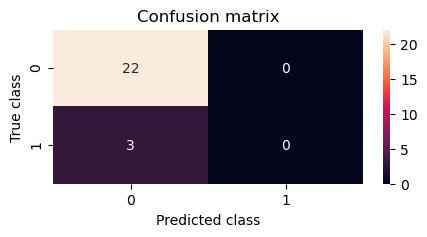

In [45]:
conf_matrix = confusion_matrix(y_test, y_pred); 
plt.figure(figsize=(5, 2)); sns.heatmap(conf_matrix,  annot=True, fmt="d");
plt.title("Confusion matrix"); plt.ylabel('True class'); plt.xlabel('Predicted class');plt.show()

<hr>

In [46]:
data["Text2"]=data.Text.apply(lambda x:  x.replace('<br />', ''))

In [47]:
mask_neg = data.Sentiment == 1
data_neg = data.loc[mask_neg, :]

text_neg = ' '.join(data_neg["Text2"])

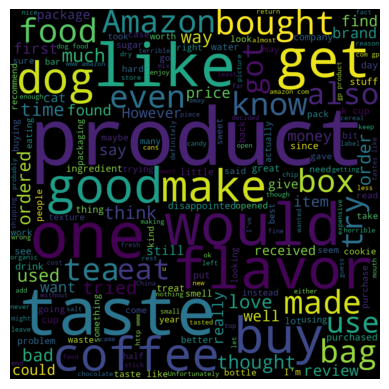

In [48]:
wordcloud_neg = WordCloud(width=1500, height=1500, margin=0,random_state=1, stopwords = stopwords_en).generate(text_neg)

plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [49]:
mask_pos = np.logical_not(mask_neg)
data_pos = data.loc[mask_pos, :]
text_pos = ' '.join(data_pos.Text2)

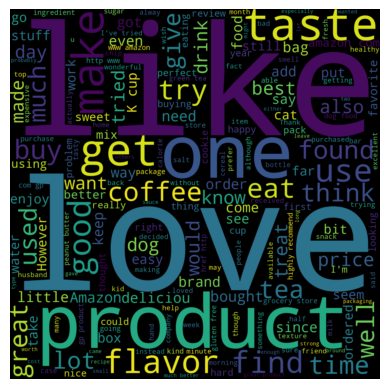

In [50]:
wordcloud_pos = WordCloud(width=1500, height=1500, margin=0, random_state=1,stopwords = stopwords_en).generate(text_pos)

plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

Hacemos una predicción:

In [53]:
datos={'Summary': ["Best quality product!"], 'Text': ['Excellent purchase!']}
datos=pd.DataFrame.from_dict(datos)

In [54]:
grid.predict(datos)

array([0], dtype=int64)